<a href="https://colab.research.google.com/github/xslittlemaggie/Deep-Learning-Projects/blob/master/Pixel_level_object(car)_segmentation_not_done_yet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 0: Import libraries & install package

In [1]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, UpSampling2D, ZeroPadding2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.utils import to_categorical

# graphs
% matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import random
import cv2
import os
import glob

Using TensorFlow backend.


In [0]:
#!pip install keras-segmentation

## Step 1: Load data from google drive

### 1. Import drive

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### 2. Copy data from google drive to colab

In [0]:
# Copy data from google drive to Colab
!cp -r "/content/drive/My Drive/Deep Learning projects/Segmentation_zip/training_data_part.zip" "/content"
!cp -r "/content/drive/My Drive/Deep Learning projects/Segmentation_zip/_out_test_crop_800_256.zip" "/content"
!cp -r "/content/drive/My Drive/Deep Learning projects/Segmentation_zip/_out_crop_800_256.zip" "/content"

### 3. Unzip files

In [6]:
!unzip -q /content/_out_test_crop_800_256.zip -d /content/_out_test_crop_800_256/
!unzip -q /content/_out_crop_800_256.zip -d /content/_out_crop_800_256/
!unzip -q /content/training_data_part.zip -d /content/training_data/

warning [/content/_out_crop_800_256.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
file #28084:  bad zipfile offset (local header sig):  289627
  (attempting to re-compensate)


## Step 2: Get familiar with the data & visualize the images

### 1. Visualize one image with the corresponding mask

The original image


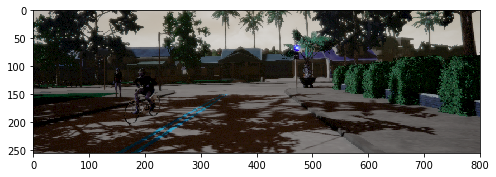

The ground truth


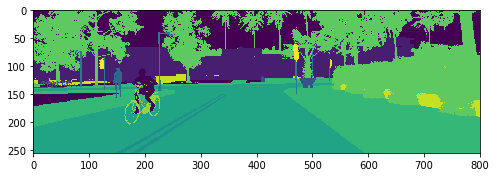

In [7]:
#fig = plt.figure(figsize = (8, 6))
img_RGB = "/content/_out_test_crop_800_256/_out_test_crop_800_256/episode_0000/CameraRGB/000030.png"
img_Seg = "/content/_out_test_crop_800_256/_out_test_crop_800_256/episode_0000/CameraSeg/000030.png"
img_RGB_array = cv2.imread(img_RGB)
img_Seg_array = cv2.imread(img_Seg)
plt.rcParams['figure.figsize'] = (8, 8)
plt.imshow(img_RGB_array)
print("The original image")
plt.show()
plt.imshow(img_Seg_array[:, :, 0])
print("The ground truth")
plt.show()

## Step 3: Create training, testing, validation files to store images, masks respectively

#### Create the global file segmentation and the sub files
 - segmentation/train_dataset
    - imgs
    - labels
    
 - segmentation/test_dataset
    - imgs
    - labels
    
 - segmentation/val_dataset
    - imgs
    - labels



In [0]:
os.mkdir('/content/segmentation/')
os.mkdir('/content/segmentation/train_dataset/')
os.mkdir('/content/segmentation/train_dataset/imgs/')
os.mkdir('/content/segmentation/train_dataset/labels/')

os.mkdir('/content/segmentation/test_dataset/')
os.mkdir('/content/segmentation/test_dataset/imgs/')
os.mkdir('/content/segmentation/test_dataset/labels/')

os.mkdir('/content/segmentation/val_dataset/')
os.mkdir('/content/segmentation/val_dataset/imgs/')
os.mkdir('/content/segmentation/val_dataset/labels/')

In [0]:
os.mkdir('/content/segmentation/test_dataset/imgs/data/')
os.mkdir('/content/segmentation/test_dataset/labels/data/')

In [0]:
os.mkdir('/content/segmentation/val_dataset/imgs/data')
os.mkdir('/content/segmentation/val_dataset/labels/data')

## Step 4: Data Preprocessing

#### 1. Move all RGB images, and Seg masks to training dataset

In [0]:
# move all RGB images from 800_256_to train_imgs
# organize training data
episodes = [i[-4:] + "/" for i in glob.glob("/content/_out_crop_800_256/_out_crop_800_256/*")]
for episode in episodes:
  pathes = glob.glob("/content/_out_crop_800_256/_out_crop_800_256/episode_" + episode + "CameraRGB/*.png")
  for path in pathes:
    img_array = cv2.imread(path)
    #try:
    #  img_array/255
    #except:
    #  print(path)
    #  break
    head, tail = os.path.split(path)
    new_path = "/content/segmentation/train_dataset/imgs/" + head[-22:-10] + "_" + tail
    os.rename(path, new_path)
    
# move all RGB images from 800_256_to train_imgs
for episode in episodes:
  pathes = glob.glob("/content/_out_crop_800_256/_out_crop_800_256/episode_" + episode + "CameraSeg/*.png")
  for path in pathes:
    img_array = cv2.imread(path)
    #try:
    #  img_array/255
    #except:
    #  print(path)
    #  break
    head, tail = os.path.split(path)
    new_path = "/content/segmentation/train_dataset/labels/" + head[-22:-10] + "_" + tail
    os.rename(path, new_path)

#### 2. Move all RGB images, and Seg masks to testing dataset

In [0]:
episodes = [i[-4:] + "/" for i in glob.glob("/content/_out_test_crop_800_256/_out_test_crop_800_256/*")]
for episode in episodes:
  pathes = glob.glob("/content/_out_test_crop_800_256/_out_test_crop_800_256/episode_" + episode + "CameraRGB/*.png")
  for path in pathes:    
    img_array = cv2.imread(path)
    head, tail = os.path.split(path)   
    new_path = "/content/segmentation/test_dataset/imgs/data/" + head[-22:-10] + "_" + tail
    os.rename(path, new_path)
    
for episode in episodes:
  pathes = glob.glob("/content/_out_test_crop_800_256/_out_test_crop_800_256/episode_" + episode + "CameraSeg/*.png")
  for path in pathes:
    img_array = cv2.imread(path)
    head, tail = os.path.split(path)
    new_path = "/content/segmentation/test_dataset/labels/data/" + head[-22:-10] + "_" + tail
    os.rename(path, new_path)

#### 3. Move all RGB images, and Seg masks to validation dataset

In [0]:
episodes = [i[-4:] + "/" for i in glob.glob("/content/training_data/training_data_part/*")]
for episode in episodes:
  pathes = glob.glob("/content/training_data/training_data_part/episode_" + episode + "CameraRGB/*.png")
  for path in pathes:    
    img_array = cv2.imread(path)
    head, tail = os.path.split(path)   
    new_path = "/content/segmentation/val_dataset/imgs/data/" + head[-22:-10] + "_" + tail
    os.rename(path, new_path)
    
for episode in episodes:
  pathes = glob.glob("/content/training_data/training_data_part/episode_" + episode + "CameraSeg/*.png")
  for path in pathes:
    img_array = cv2.imread(path)
    head, tail = os.path.split(path)
    new_path = "/content/segmentation/val_dataset/labels/data/" + head[-22:-10] + "_" + tail
    os.rename(path, new_path)

#### 4. About the final training data

In [14]:
dir_train_images = '/content/segmentation/train_dataset/imgs'
dir_train_labels = '/content/segmentation/train_dataset/labels'

dir_train_images_fname = os.listdir(dir_train_images)
dir_train_labels_fname = os.listdir(dir_train_labels)

print("Total training images:", len(dir_train_images_fname))
print("Total training masks:", len(dir_train_labels_fname))

Total training images: 14400
Total training masks: 14400


#### 5. About the final testing data

In [15]:
dir_test_images = '/content/segmentation/test_dataset/imgs/data'
dir_test_labels = '/content/segmentation/test_dataset/labels/data'

dir_test_images_fname = os.listdir(dir_test_images)
dir_test_labels_fname = os.listdir(dir_test_labels)

print("Total testing images:", len(dir_test_images_fname))
print("Total testing masks:", len(dir_test_labels_fname))

Total testing images: 2400
Total testing masks: 2400


#### 6. About the final validation data

In [16]:
dir_val_images = '/content/segmentation/val_dataset/imgs/data'
dir_val_labels = '/content/segmentation/val_dataset/labels/data'

dir_val_images_fname = os.listdir(dir_val_images)
dir_val_labels_fname = os.listdir(dir_val_labels)

print("Total validation images:", len(dir_val_images_fname))
print("Total validation masks:", len(dir_val_labels_fname))

Total validation images: 2700
Total validation masks: 2700


## Step 5: Images & segmentations preparation

### 1. Define the get_image_arr (input from the model)

In [21]:
def get_image_arr(path):
  img = cv2.imread(path)
  img = img.astype(np.float32)
  img = img/255.0
  
  return img

# example
path = "/content/segmentation/train_dataset/imgs/episode_0069_000102.png"
get_image_arr(path).shape

(256, 800, 3)

### 2. Define get_segmentation_arr (output from the model)

In [25]:
def get_segmentation_arr(path):
  
  height = 128
  width = 400
  n_classes = 13
  
  seg_labels = np.zeros((height, width, n_classes))
  img = path
  
  img = cv2.imread(path)
  img = cv2.resize(img, (width, height))  # interpolation = by_default
  img = img[:, :, 0]
  
  for c in range(n_classes):
    seg_labels[:, :, c] = (img == c).astype(int)
  
  seg_labels = np.reshape(seg_labels, (width * height, n_classes))
  
  return seg_labels

# example
path = "/content/segmentation/train_dataset/labels/episode_0069_000102.png"
get_segmentation_arr(path).shape

(51200, 13)

### 3. Define TrainGenerator (one batch of data into the model each time)

In [34]:
import random
import itertools

def TrainGenerator(batch_size = 2):
    
  output_height = 128
  output_width = 400
  n_classes = 13
  
  images_path = glob.glob("/content/segmentation/train_dataset/imgs/*.png")
  segs_path = glob.glob("/content/segmentation/train_dataset/labels/*.png")
  N = len(images_path)
  
 
  # step 1: pair
  pairs = [[images_path[i], segs_path[i]] for i in range(N)]
  random.shuffle(pairs)
  zipped = itertools.cycle(pairs)
  
  while True:
    X = []
    Y = []
    
    for i in range(batch_size):
      img, seg = next(zipped)
      X.append(get_image_arr(img))
      Y.append(get_segmentation_arr(seg))
    
    yield np.array(X), np.array(Y)
    
# example

storage =  TrainGenerator(batch_size = 2)
for (img, seg) in storage:
  print(img.shape)
  print(seg.shape)
  
  break

(2, 256, 800, 3)
(2, 51200, 13)


## Step 5: Model building

### 1. Define encoder (The first half of the model)

In [0]:
IMAGE_ORDERING = 'channels_last'

def encoder(input_height = 256, input_width = 800):
  
  if IMAGE_ORDERING == "channels_first":
    img_input = Input(shape = (3, input_height, input_width))
  
  elif IMAGE_ORDERING == "channels_last":
    img_input = Input(shape = (input_height, input_width, 3))
    
  x = img_input
  
  blocks = []
  
  # first block
  x = (ZeroPadding2D((1, 1), data_format = IMAGE_ORDERING))(x)                  
  x = (Conv2D(64, (3, 3), data_format = IMAGE_ORDERING, padding = "valid"))(x)  
  x = (BatchNormalization())(x)
  x = (Activation("relu"))(x)
  x = (MaxPooling2D((2, 2), data_format = IMAGE_ORDERING))(x)                   
  blocks.append(x)
  # --> 400 * 128 * 64 * (3)
  
  # second block
  x = (ZeroPadding2D((1, 1), data_format = IMAGE_ORDERING))(x)
  x = (Conv2D(128, (3, 3), data_format = IMAGE_ORDERING, padding = "valid"))(x)
  x = (BatchNormalization())(x)
  x = (Activation("relu"))(x)
  x = (MaxPooling2D((2, 2), data_format = IMAGE_ORDERING))(x)
  blocks.append(x) 
  # --> 200 * 64 * 128 * (64 * 3)
  
  # third block
  x = (ZeroPadding2D((1, 1), data_format = IMAGE_ORDERING))(x)
  x = (Conv2D(256, (3, 3), data_format = IMAGE_ORDERING, padding = "valid"))(x)
  x = (BatchNormalization())(x)
  x = (Activation("relu"))(x)
  x = (MaxPooling2D((2, 2), data_format = IMAGE_ORDERING))(x)
  blocks.append(x)
  # --> 100 * 32 * 256 * (128 * 64 * 3)
  
  
  # fourth block
  x = (ZeroPadding2D((1, 1), data_format = IMAGE_ORDERING))(x)
  x = (Conv2D(256, (3, 3), data_format = IMAGE_ORDERING, padding = "valid"))(x)
  x = (BatchNormalization())(x)
  x = (Activation("relu"))(x)
  x = (MaxPooling2D((2, 2), data_format = IMAGE_ORDERING))(x)
  blocks.append(x)
  # --> 50 * 16 * 256 * (256 * 128 * 64 * 3)
  
  # fifth block
  x = (ZeroPadding2D((1, 1), data_format = IMAGE_ORDERING))(x)
  x = (Conv2D(256, (3, 3), data_format = IMAGE_ORDERING, padding = "valid"))(x)
  x = (BatchNormalization())(x)
  x = (Activation("relu"))(x)
  x = (MaxPooling2D((2, 2), data_format = IMAGE_ORDERING))(x)
  blocks.append(x)
  # --> 25 * 8 * 256 * (256 * 256 * 128 * 64 * 3)
  
  return img_input, blocks

In [47]:
encoder(input_height = 800, input_width = 256)

(<tf.Tensor 'input_3:0' shape=(?, 800, 256, 3) dtype=float32>,
 [<tf.Tensor 'max_pooling2d_11/MaxPool:0' shape=(?, 400, 128, 64) dtype=float32>,
  <tf.Tensor 'max_pooling2d_12/MaxPool:0' shape=(?, 200, 64, 128) dtype=float32>,
  <tf.Tensor 'max_pooling2d_13/MaxPool:0' shape=(?, 100, 32, 256) dtype=float32>,
  <tf.Tensor 'max_pooling2d_14/MaxPool:0' shape=(?, 50, 16, 256) dtype=float32>,
  <tf.Tensor 'max_pooling2d_15/MaxPool:0' shape=(?, 25, 8, 256) dtype=float32>])

### 2. Define seg_model (The second half of the model)

In [0]:
def get_segmentation_model(input, output):
  img_input = input
  o = output
  
  o_shape = Model(img_input, o).output_shape
  i_shape = Model(img_input, o).input_shape
  
  if IMAGE_ORDERING == "channels_first":
    n_classes = o_shape[1]
    
    output_height = o_shape[2]
    output_width = o_shape[3]
    
    input_height = i_shape[2]
    input_width = i_shape[3]
    
    o = (Reshape((-1, output_height * output_width)))(o)
    o = (Permute((2, 1)))(o)
    
    
  elif IMAGE_ORDERING == "channels_last":
    n_classes = o_shape[3]
    
    output_height = o_shape[1]
    output_width = o_shape[2]
    
    input_height = i_shape[1]
    input_width = i_shape[2]
    
    o = (Reshape((output_height * output_width, -1)))(o)

    
  o = (Activation("softmax"))(o)
  model = Model(img_input, o)
  model.output_width = output_width
  model.output_height = output_height
  model.n_classes = n_classes
  model.input_height = input_height
  model.input_width = input_width
  
  model.model_name = "My_Segmentation_Unet"
  
  #model.train = MethodType(train, model)
  #model.predict_segmentation = MethodType(predict, model)
  #model.predict_multiple = MethodType(predict_multiple, model)
  #model.evaluate_segmentation = MethodType(evaluate, model)
  
  return model
    

### 2. define the myUnet (The last part of the model)

In [0]:
if IMAGE_ORDERING == 'channels_first':
	MERGE_AXIS = 1
elif IMAGE_ORDERING == 'channels_last':
	MERGE_AXIS = -1

def myUnet(n_classes, input_height = 256, input_width = 800): # encoder, 
  
  img_input, blocks = encoder(input_height = 256, input_width = 800)
  [f1, f2, f3, f4, f5] = blocks
  
  o = f4
  o = (ZeroPadding2D((1, 1), data_format = IMAGE_ORDERING))(o)
  o = (Conv2D(512, (3, 3), padding = "valid", data_format = IMAGE_ORDERING))(o)
  o = (BatchNormalization())(o)
  
  o = (UpSampling2D((2, 2), data_format = IMAGE_ORDERING))(o)
  
  o = (concatenate([o, f3], axis = MERGE_AXIS))
  o = (ZeroPadding2D((1, 1), data_format = IMAGE_ORDERING))(o)
  o = (Conv2D(256, (3, 3), padding = "valid", data_format = IMAGE_ORDERING))(o)
  o = (BatchNormalization())(o)
  
  o = (UpSampling2D((2, 2), data_format = IMAGE_ORDERING))(o)
  
  o = (concatenate([o, f2], axis = MERGE_AXIS))
  o = (ZeroPadding2D((1, 1), data_format = IMAGE_ORDERING))(o)
  o = (Conv2D(128, (3, 3), padding = "valid", data_format = IMAGE_ORDERING))(o)
  o = (BatchNormalization())(o)
  
  o = (UpSampling2D((2, 2), data_format = IMAGE_ORDERING))(o)
  
  o = (concatenate([o, f1], axis = MERGE_AXIS))
  o = (ZeroPadding2D((1, 1), data_format = IMAGE_ORDERING))(o)
  o = (Conv2D(64, (3, 3), padding = "valid", data_format = IMAGE_ORDERING))(o)
  o = (BatchNormalization())(o)
  
  o = (Conv2D(n_classes, (3, 3), padding = "same", data_format = IMAGE_ORDERING))(o)
  
  model = get_segmentation_model(img_input, o)
  
  return model

In [0]:
from keras.utils import plot_model
from IPython.display import Image

#plot_model(model, to_file = "seg.png", show_shapes = True)
#Image("seg.png")

In [51]:
from keras.layers import Reshape
model = myUnet(n_classes = 13, input_height = 256, input_width = 800)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 800, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_20 (ZeroPadding2 (None, 258, 802, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 800, 64) 1792        zero_padding2d_20[0][0]          
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 256, 800, 64) 256         conv2d_21[0][0]                  
____________________________________________________________________________________________

## Step 6: Training

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=30, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-car-detection.h5', verbose=1, save_best_only=True, save_weights_only=True)]

In [53]:
history = model.fit_generator(TrainGenerator(), 
                              epochs = 10, 
                              steps_per_epoch = 35,  # number of training_images / batch_size
                              #validation_data =test_generator,
                              validation_steps = 7)

model.save('model-car-detection.h5')

Epoch 1/10
35/35 [==============================] - 18s 518ms/step - loss: 0.1910 - acc: 0.9380
Epoch 2/10
35/35 [==============================] - 9s 266ms/step - loss: 0.1636 - acc: 0.9445
Epoch 3/10
35/35 [==============================] - 9s 270ms/step - loss: 0.1469 - acc: 0.9509
Epoch 4/10
35/35 [==============================] - 9s 270ms/step - loss: 0.1382 - acc: 0.9538
Epoch 5/10
35/35 [==============================] - 9s 270ms/step - loss: 0.1457 - acc: 0.9508
Epoch 6/10
35/35 [==============================] - 9s 270ms/step - loss: 0.1354 - acc: 0.9540
Epoch 7/10
35/35 [==============================] - 9s 271ms/step - loss: 0.1253 - acc: 0.9578
Epoch 8/10
35/35 [==============================] - 9s 271ms/step - loss: 0.1260 - acc: 0.9571
Epoch 9/10
35/35 [==============================] - 9s 270ms/step - loss: 0.1264 - acc: 0.9567
Epoch 10/10
35/35 [==============================] - 9s 270ms/step - loss: 0.1220 - acc: 0.9595


## Step 7: Prediction

In [0]:
def decoder()

In [68]:
arr = np.array(range(16)).reshape(2, 2, 4)
arr

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7]],

       [[ 8,  9, 10, 11],
        [12, 13, 14, 15]]])

In [86]:

print("The shape before max:", arr.shape)
maxInColumns = np.amax(arr, axis=2)
 
print('Max value of every column: ', maxInColumns)
print("The shape after max:", maxInColumns.shape)


The shape before max: (2, 2, 4)
Max value of every column:  [[ 3  7]
 [11 15]]
The shape after max: (2, 2)


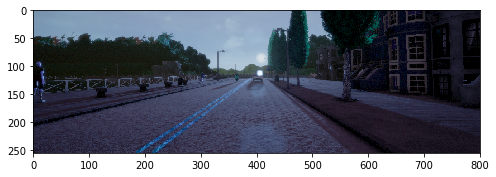

(1, 51200, 13)
The shape after max: (128, 400)


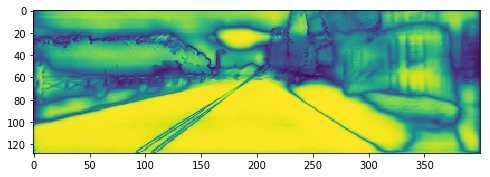

(51200, 13)


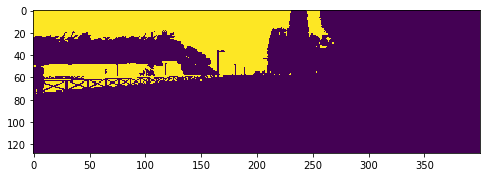

In [95]:
img_pathes = glob.glob("/content/segmentation/train_dataset/imgs/*.png")
mask_pathes = glob.glob("/content/segmentation/train_dataset/labels/*.png")
#img_path = "/content/segmentation/train_dataset/imgs/episode_0005_000034.png"
imgs = myGenerator()
for img, seg in imgs:
  plt.imshow(img[0])
  plt.show()
  
  # the predicted mask
  pred = model.predict(np.array([img[0]]))
  print(pred.shape)
  pred = np.reshape(pred, (128, 400, 13))
  pred_max = np.amax(pred, axis = 2)
  print("The shape after max:", pred_max.shape)
  plt.imshow(pred_max)
  plt.show()
  
  # the ground truth
  print(seg[0].shape)
  
  true = np.reshape(seg[0], (128, 400, 13))
  #true_max = np.amax(true, axis = 2)
  #print("The shape after max:", pred_max.shape)
  plt.imshow(true[:,:, 0])
  plt.show()
  
  break





Image # 1
The origianl image


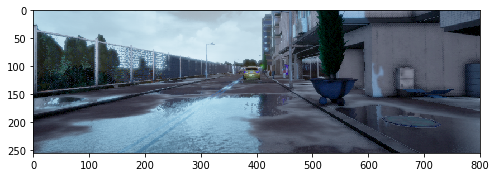

The predicted image


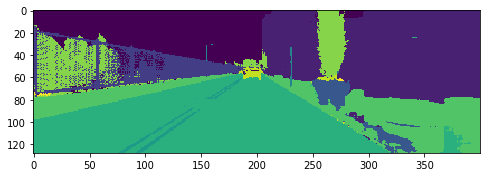

The ground truth


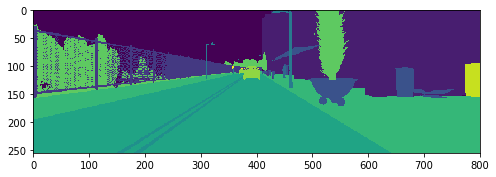

************************************************************
************************************************************
Image # 2
The origianl image


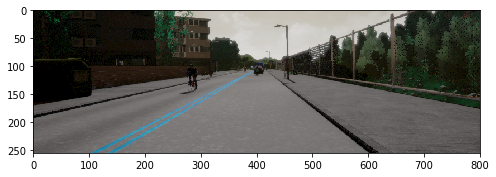

The predicted image


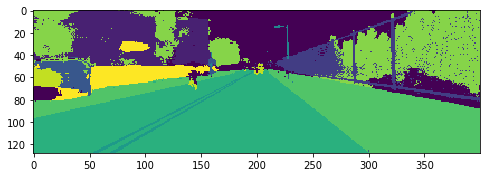

The ground truth


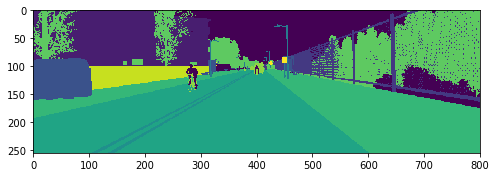

************************************************************
************************************************************


In [0]:
img_pathes = glob.glob("/content/segmentation/train_dataset/imgs/*.png")
mask_pathes = glob.glob("/content/segmentation/train_dataset/labels/*.png")
#img_path = "/content/segmentation/train_dataset/imgs/episode_0005_000034.png"
for i in range(2):
  predicted = model.predict_segmentation(inp=img_pathes[i], out_fname="/tmp/out.png")
  print("Image # {}".format(i + 1))
  print("The origianl image")
  plt.imshow(cv2.imread(img_pathes[i]))
  plt.show()
  print("The predicted image")
  plt.imshow(predicted)
  plt.show()
  print("The ground truth")
  plt.imshow(cv2.imread(mask_pathes[i])[:, :, 0])
  plt.show()
  print("*" * 60)
  print("*" * 60)